# Baseline Classification with Macro Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# feature selection
from info_gain import info_gain
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler
# models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Macro Data Preprocessing

In [112]:
df = pd.read_csv('raw_data.txt')

In [113]:
df.tail()

,date,DFEDTARL,DFEDTARU,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,DFF,minutes,speeches,statements,testimony,pressconf,text
178,2020-11-30,0.0,0.25,18794.426,260.927,6.7,142809.0,208966.0,27747798.0,24.806000,0.086333,"December 15-16, 2020\nA joint meeting of the ...",The Federal Reserve is committed to providing...,The Federal Reserve is committed to using its...,Chair Powell submitted identical remarks to t...,CHAIR POWELL. Good afternoon. At the Federa...,"December 15-16, 2020\nA joint meeting of the ..."
179,2020-12-31,0.0,0.25,18794.426,261.560,6.7,142503.0,205818.0,27747798.0,22.198710,0.090000,"January 26-27, 2021A joint meeting of the Fed...",Current Economic Situation and Outlook\nIn th...,The Federal Reserve is committed to using its...,NaN,CHAIR POWELL. Good afternoon. At the Federa...,"January 26-27, 2021A joint meeting of the Fed..."
180,2021-01-31,0.0,0.25,18794.426,262.231,6.3,142669.0,220845.0,27747798.0,24.763871,0.085161,NaN,Today I will discuss the state of our labor m...,NaN,Chair Powell submitted identical remarks to t...,NaN,Today I will discuss the state of our labor m...
181,2021-02-28,0.0,0.25,18794.426,263.161,6.2,143048.0,213438.0,27747798.0,22.904286,0.075714,NaN,The Dash for Cash\nInvestor sentiment shifted...,The Federal Reserve is committed to using its...,Chair Powell submitted identical remarks to t...,PRELIMINARY Transcript of Chair Powell’s Pres...,The Dash for Cash\nInvestor sentiment shifted...
182,2021-03-31,0.0,0.25,18794.426,263.161,6.2,143048.0,213438.0,27747798.0,21.891429,0.070000,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
df = df.iloc[:-1]

In [115]:
df.drop(['minutes', 'speeches', 
         'statements', 'testimony', 
         'pressconf', 'text'], 
        axis=1, 
        inplace=True)

In [116]:
df.head()

,date,DFEDTARL,DFEDTARU,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,DFF
0,2006-01-31,NaN,NaN,15267.026,199.3,4.7,135429.0,179293.0,8371156.0,12.050690,4.285161
1,2006-02-28,NaN,NaN,15267.026,199.4,4.8,135737.0,177887.0,8371156.0,12.412857,4.491429
2,2006-03-31,NaN,NaN,15267.026,199.7,4.7,136047.0,178100.0,8371156.0,11.716129,4.589355
3,2006-04-30,NaN,NaN,15302.705,200.7,4.7,136205.0,178088.0,8420042.0,11.863333,4.790333
4,2006-05-31,NaN,NaN,15302.705,201.3,4.6,136244.0,177200.0,8420042.0,14.411613,4.940323


In [117]:
def count_missing(data):
    """
    method to count number of missing values in each column
    inputs:
        data - dataframe
    output:
        returns df sorted according to num of missing values
    """
    key_value = {}
    col_name = []
    num_na = []
    for col in data.columns:
        col_name.append(col)
        num_na.append(data[col].isna().sum())
    key_value['Column Name'] = col_name
    key_value['Number of NAs'] = num_na
    return pd.DataFrame(key_value)

In [118]:
count_missing(df)

,Column Name,Number of NAs
0,date,0
1,DFEDTARL,35
2,DFEDTARU,35
3,GDPC1,0
4,CPIAUCSL,0
5,UNRATE,0
6,PAYEMS,0
7,RRSFS,0
8,GFDEBTN,0
9,VIXCLS,0


In [119]:
def preprocessing(data):
    '''
    Description: Drop date, DFEDTARL and DFEDTARU, 
                 generate target variable column, 
                 and drop first row.

    Input:
    * Pandas DataFrame: Dataframe to be preprocessed.

    Return:
    * Pandas DataFrame: Dataframe with NA filled, 
                        target column generated, 
                        and first row dropped.
    '''
    
    data['diff'] = data['DFF'].diff()
    data['target'] = [1 if x > 0.01 
                      else -1 if x < -0.01 
                      else 0 
                      for x in data['diff']]
    
    to_drop = ['date', 'DFEDTARL', 'DFEDTARU', 'diff']
    data.drop(to_drop, axis=1, inplace=True)
    data = data.iloc[1:,:]
    
    return data

In [120]:
df = preprocessing(df)

In [121]:
pd.DataFrame(df.target.value_counts())

,target
0,80
1,57
-1,44


In [122]:
df.head()

,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,DFF,target
1,15267.026,199.4,4.8,135737.0,177887.0,8371156.0,12.412857,4.491429,1
2,15267.026,199.7,4.7,136047.0,178100.0,8371156.0,11.716129,4.589355,1
3,15302.705,200.7,4.7,136205.0,178088.0,8420042.0,11.863333,4.790333,1
4,15302.705,201.3,4.6,136244.0,177200.0,8420042.0,14.411613,4.940323,1
5,15302.705,201.8,4.6,136325.0,177343.0,8420042.0,16.779000,4.991000,1


### Train Test Split

In [123]:
X = df.drop(columns=['target'])
y = df.target
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    test_size=0.2, 
                                                    shuffle=False)

### Feature Scaling

In [124]:
pd.DataFrame(X_train[:5])

,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,DFF
1,15267.026,199.4,4.8,135737.0,177887.0,8371156.0,12.412857,4.491429
2,15267.026,199.7,4.7,136047.0,178100.0,8371156.0,11.716129,4.589355
3,15302.705,200.7,4.7,136205.0,178088.0,8420042.0,11.863333,4.790333
4,15302.705,201.3,4.6,136244.0,177200.0,8420042.0,14.411613,4.940323
5,15302.705,201.8,4.6,136325.0,177343.0,8420042.0,16.779000,4.991000


In [125]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [126]:
pd.DataFrame(X_train[:5])

,0,1,2,3,4,5,6,7
0,-1.130742,-1.967195,-0.918581,-0.325537,0.028569,-1.609374,-0.742005,1.858206
1,-1.130742,-1.944672,-0.970372,-0.263516,0.048022,-1.609374,-0.818080,1.912895
2,-1.094055,-1.869597,-0.970372,-0.231906,0.046926,-1.597019,-0.802007,2.025136
3,-1.094055,-1.824551,-1.022164,-0.224103,-0.034174,-1.597019,-0.523763,2.108901
4,-1.094055,-1.787014,-1.022164,-0.207898,-0.021114,-1.597019,-0.265271,2.137203


### Feature Selection

#### Information Gain Ratio

In [127]:
cols = df.iloc[:, :-1].columns
igr_list = []
for col in cols:
    key_value = [col]
    igr = info_gain.info_gain_ratio(df['target'].values.tolist(),
                                    df[col].values.tolist())
    key_value.append(igr)
    igr_list.append(key_value)
igr_list = sorted(igr_list, key=lambda x: x[1], reverse=True)

In [128]:
igr_list

[['CPIAUCSL', 0.14289734153473],
 ['RRSFS', 0.1424762725758933],
 ['PAYEMS', 0.14166375728218206],
 ['VIXCLS', 0.14166375728218206],
 ['DFF', 0.14065596890528995],
 ['GDPC1', 0.10108780402805446],
 ['GFDEBTN', 0.09381973062759424],
 ['UNRATE', 0.09050002536674114]]

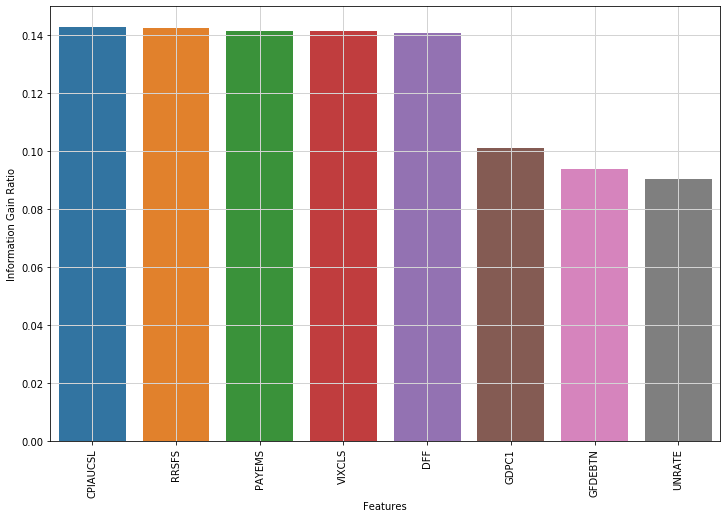

In [129]:
plt.figure(figsize=(12,8))
ax = sns.barplot(x="Features", 
                 y="Information Gain Ratio", 
                 data=pd.DataFrame(igr_list, 
                                   columns=['Features', 
                                            'Information Gain Ratio']))
plt.xticks(rotation='vertical')
ax.grid(b=True, which='major', color='#d3d3d3', linewidth=1.0)
ax.grid(b=True, which='minor', color='#d3d3d3', linewidth=0.5)
plt.show()

#### Variance Inflation Factor

In [130]:
def cal_vif(x):
    thresh = 5
    output = pd.DataFrame()
    k = x.shape[1]
    vif = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    for i in range(1, k):
        print('Iteration no ', i)
        print(vif)
        a = np.argmax(vif)
        print('Max vif ', a)
        if vif[a] <= thresh:
            break
        if i == 1:
            output = x.drop(x.columns[a], axis=1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
        elif i > 1:
            output = output.drop(output.columns[a], axis=1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
    return output

x = pd.DataFrame(X_train)
selected_features = cal_vif(x)
selected_features.head()

Iteration no  1
[130.82613521926402, 49.81493676815885, 69.8573385461285, 107.75762074321858, 71.60139963103732, 71.55850924778873, 3.272631167264386, 27.35605981604291]
Max vif  0
Iteration no  2
[49.3976265377466, 56.76368932198085, 43.97901056352148, 60.48288118286271, 55.63714023153695, 3.2124404645822695, 26.742700248761007]
Max vif  3
Iteration no  3
[40.361688037568406, 30.62681985383739, 38.62223235662647, 33.245687716552425, 2.6913261507868285, 16.980427249553035]
Max vif  0
Iteration no  4
[30.376443430825734, 33.834479015709086, 19.12940410034964, 2.5650360436366832, 14.130671956970067]
Max vif  1
Iteration no  5
[5.360720122563471, 11.148174142717973, 2.282262836138926, 14.107252934676726]
Max vif  3
Iteration no  6
[1.2074603244274726, 1.1518010485266708, 1.3715201393328245]
Max vif  2


,2,5,6
0,-0.918581,-1.609374,-0.742005
1,-0.970372,-1.609374,-0.818080
2,-0.970372,-1.597019,-0.802007
3,-1.022164,-1.597019,-0.523763
4,-1.022164,-1.597019,-0.265271


In [131]:
for i in selected_features.columns.tolist():
    print(df.columns[i])

UNRATE
GFDEBTN
VIXCLS


#### Random Forest Feature Importance 

In [132]:
rf_clf = RandomForestClassifier().fit(X_train, y_train)

In [133]:
rf_clf.feature_importances_

array([0.08485007, 0.15941604, 0.10814828, 0.13866646, 0.13439602,
       0.10609128, 0.14209411, 0.12633774])

In [134]:
importance = rf_clf.feature_importances_

Feature: 0, Score: 0.08485
Feature: 1, Score: 0.15942
Feature: 2, Score: 0.10815
Feature: 3, Score: 0.13867
Feature: 4, Score: 0.13440
Feature: 5, Score: 0.10609
Feature: 6, Score: 0.14209
Feature: 7, Score: 0.12634


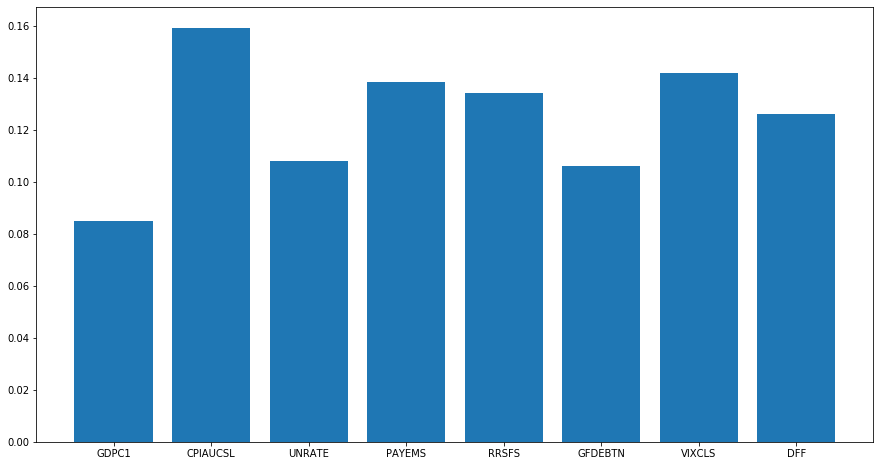

In [135]:
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(15,8))
plt.bar([X.columns[x] for x in range(len(importance))], importance)
plt.show()

#### Final Feature Set

In [136]:
igr_top_3 = [x[0] for x in igr_list][:3]

In [137]:
vif_top_3 = [df.columns[x] for x in list(selected_features.columns)][:3]

In [138]:
indices = np.argsort(rf_clf.feature_importances_)[::-1] # increasing order
rf_top_3 = [df.columns[x] for x in indices][:3]

##### Unique Top 3 Features from each Method

In [139]:
final_set = []
for i in igr_top_3:
    if i not in final_set:
        final_set.append(i)
for j in vif_top_3:
    if j not in final_set:
        final_set.append(j)
for k in rf_top_3:
    if k not in final_set:
        final_set.append(k)
final_set

['CPIAUCSL', 'RRSFS', 'PAYEMS', 'UNRATE', 'GFDEBTN', 'VIXCLS']

In [140]:
igr_top_1 = [x[0] for x in igr_list][0]

In [141]:
vif_top_1 = [df.columns[x] for x in list(selected_features.columns)][0]

In [142]:
indices_1 = np.argsort(rf_clf.feature_importances_)[::-1] # increasing order
rf_top_1 = [df.columns[x] for x in indices_1][0]

In [143]:
final_set_1=[igr_top_1, vif_top_1, rf_top_1]

### Model Selection (All Features)

#### Support Vector Classification, Decision Tree, Logistic Regression with Time Series Split

In [144]:
classifiers = []
classifiers.extend([("SVC", SVC(random_state=1)), 
                    ("Decision Tree", DecisionTreeClassifier(random_state=1)), 
                    ("Logistic Regression", LogisticRegression(random_state=1))])

In [145]:
results = []
classifier_name = []
for classifier in classifiers:
    tscv = TimeSeriesSplit(n_splits=5)
    all_y_preds = []
    all_y_true = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index[0]:train_index[-1]+1], X[test_index[0]:test_index[-1]+1]
        y_train, y_test = y[train_index[0]:train_index[-1]+1], y[test_index[0]:test_index[-1]+1]
        classifier[1].fit(X_train, y_train)
        y_preds = classifier[1].predict(X_test)
        all_y_preds.extend(y_preds)
        all_y_true.extend(y_test)
    results.append(f1_score(all_y_true,all_y_preds, average='weighted'))
    classifier_name.append(classifier[0])

In [156]:
before_fs = pd.DataFrame([classifier_name, results]).transpose()\
                                                    .rename(columns={0:'Model',\
                                                                     1:'F1-Weighted'})\
                                                    .sort_values(by='F1-Weighted', \
                                                                 ascending=False)
before_fs

,Model,F1-Weighted
2,Logistic Regression,0.380618
0,SVC,0.378253
1,Decision Tree,0.357567


### Model Selection (Using only Final Feature Set)

In [147]:
final_set_1.append('target')
df_fs = df[final_set_1]
X = df_fs.drop(columns=['target'])
y = df_fs.target

In [151]:
classifiers_fs = []
classifiers_fs.extend([("SVC (with feature selection)", SVC(random_state=1)), 
                       ("Decision Tree (with feature selection)", DecisionTreeClassifier(random_state=1)), 
                       ("Logistic Regression (with feature selection)", LogisticRegression(random_state=1))
                      ])

In [152]:
results_fs = []
classifier_name_fs = []
for classifier in classifiers_fs:
    tscv = TimeSeriesSplit(n_splits=5)
    all_y_preds = []
    all_y_true = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index[0]:train_index[-1]+1], X[test_index[0]:test_index[-1]+1]
        y_train, y_test = y[train_index[0]:train_index[-1]+1], y[test_index[0]:test_index[-1]+1]
        classifier[1].fit(X_train, y_train)
        y_preds = classifier[1].predict(X_test)
        all_y_preds.extend(y_preds)
        all_y_true.extend(y_test)
    results_fs.append(f1_score(all_y_true,all_y_preds, average='weighted'))
    classifier_name_fs.append(classifier[0])

In [157]:
after_fs = pd.DataFrame([classifier_name_fs, results_fs]).transpose()\
                                                         .rename(columns={0:'Model',\
                                                                          1:'F1-Weighted'})\
                                                         .sort_values(by='F1-Weighted', \
                                                                      ascending=False)
after_fs

,Model,F1-Weighted
1,Decision Tree (with feature selection),0.475371
0,SVC (with feature selection),0.378253
2,Logistic Regression (with feature selection),0.297011


##### Evaluation

In [160]:
concat_results = pd.concat([before_fs, after_fs]).sort_values(by='F1-Weighted', ascending=False)
concat_results

,Model,F1-Weighted
1,Decision Tree (with feature selection),0.475371
2,Logistic Regression,0.380618
0,SVC,0.378253
0,SVC (with feature selection),0.378253
1,Decision Tree,0.357567
2,Logistic Regression (with feature selection),0.297011
